INFO:bokeh.core.state:Session output file 'original.html' already exists, will be overwritten.


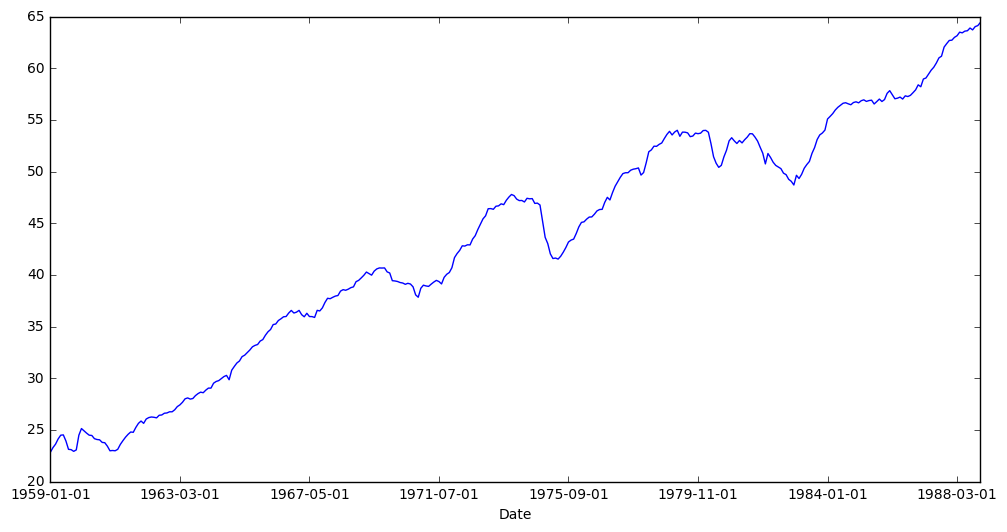

In [454]:
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
from bokeh.charts import TimeSeries, output_file, show
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
buf = pd.read_csv("training.txt", index_col = 'Date')
ts = buf['Value']
ts.plot()
#bookeh:
output_file("original.html")
ts.index = pd.to_datetime(ts.index)
p = TimeSeries(ts, x = 'index', builder_type = 'line', title="Временной ряд")
#show(p)

In [455]:
from statsmodels.tsa.stattools import adfuller
def test_stat(tser):
    #Построение скользящий статистик:
    orig = tser.plot(color='blue',label='Original')
    mean = tser.rolling(window=12,center=False).mean().plot(color='red', label='Rolling Mean')
    std = tser.rolling(window=12,center=False).std().plot(color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Тест Дики-Фуллера
    test = adfuller(tser)
    print('Test Statistic:', test[0])
    print('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0] > test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')
    V = (tser.std() / tser.mean())
    print('Коэффициент вариации', V)

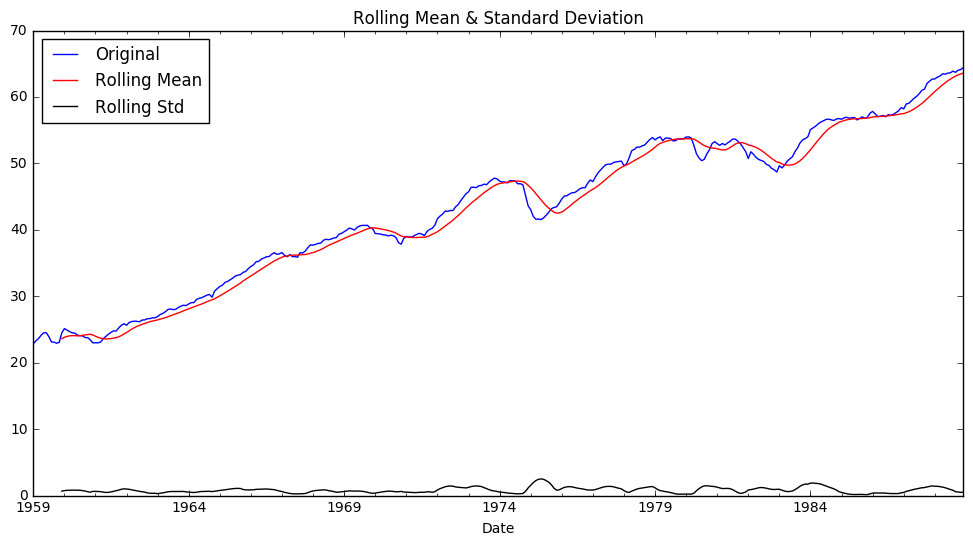

Test Statistic: -0.253391179928
p-value:  0.931851042299
Critical values:  {'1%': -3.4489583388155194, '10%': -2.5711381780459002, '5%': -2.869739378430086}
есть единичные корни, ряд не стационарен
Коэффициент вариации 0.26405212570726083


In [456]:
test_stat(ts)

/Users/MadiyaRR/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


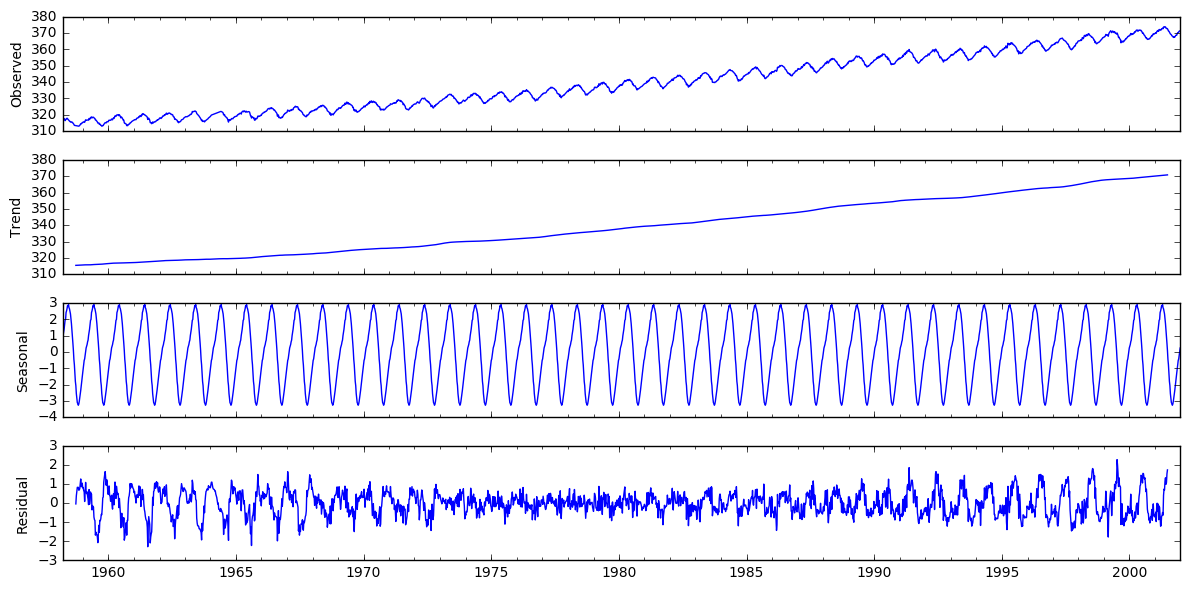

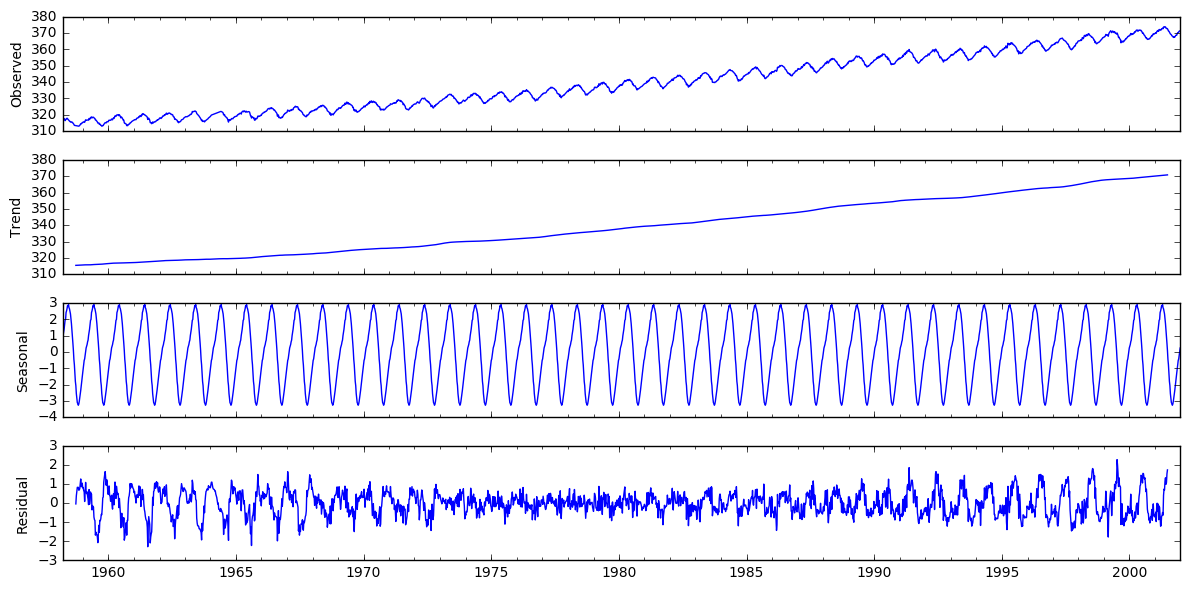

In [439]:
#Разложение временного ряда на тренд, сезональность и остаток
import statsmodels.api as sm
ts = sm.datasets.co2.load_pandas().data
ts.co2.interpolate(inplace=True)
decomp = sm.tsa.seasonal_decompose(ts.co2)
decomp.plot()

Проверим стационарность тренда:


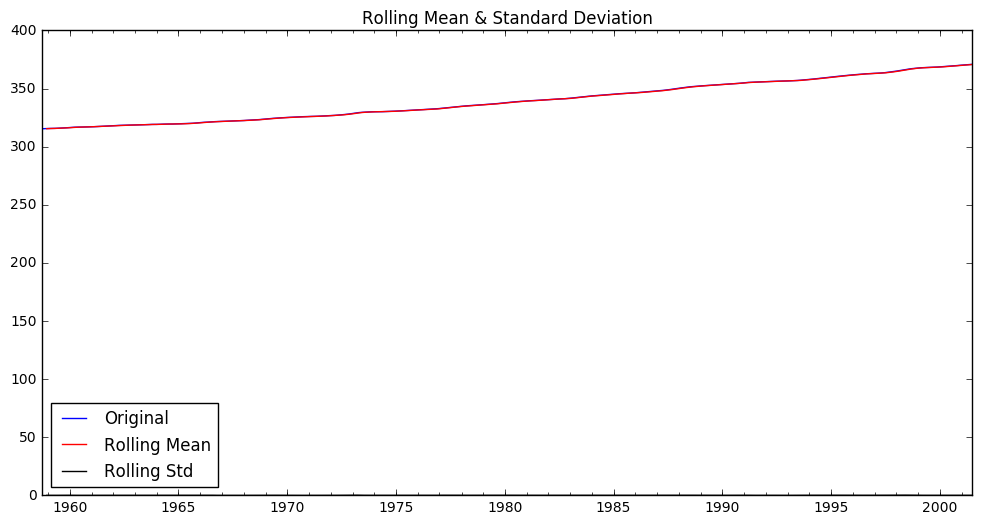

Test Statistic: 2.11167676459
p-value:  0.998801597294
Critical values:  {'1%': -3.4333191288144413, '10%': -2.5674682648176428, '5%': -2.8628516682161713}
есть единичные корни, ряд не стационарен
Коэффициент вариации 0.04901934218202125

Проверим стационарность функции сезональности:


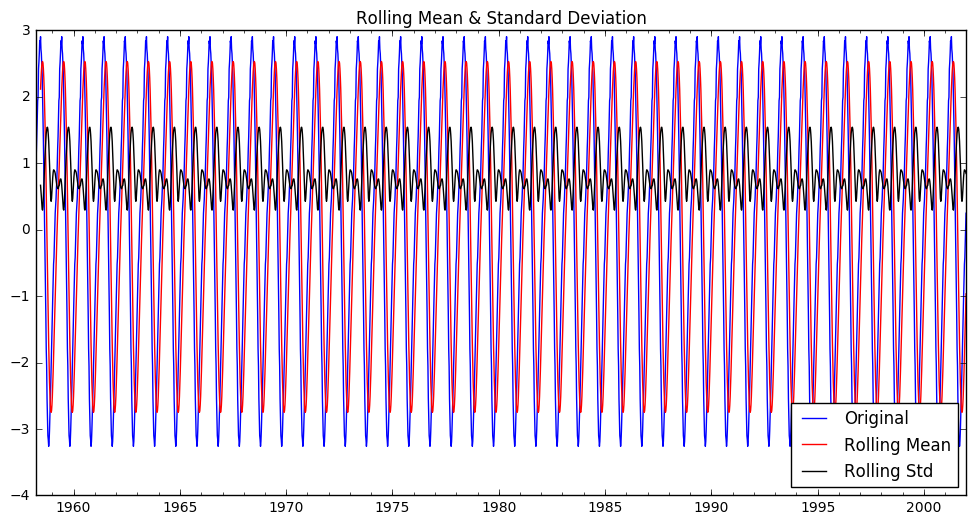

Test Statistic: -28.4197318968
p-value:  0.0
Critical values:  {'1%': -3.4332519309441296, '10%': -2.5674524668103338, '5%': -2.8628219967376647}
единичных корней нет, ряд стационарен
Коэффициент вариации -2075.0994826526526

Проверим стационарность остатка:


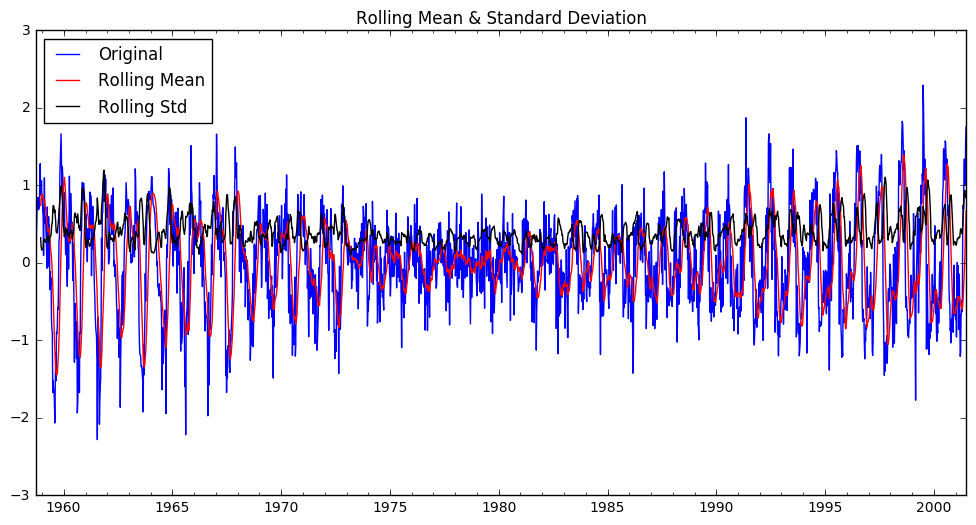

Test Statistic: -15.7574489293
p-value:  1.2028720073e-28
Critical values:  {'1%': -3.4333204775429715, '10%': -2.5674685818969634, '5%': -2.8628522637456255}
единичных корней нет, ряд стационарен
Коэффициент вариации 152.76286051356158


In [400]:
print('Проверим стационарность тренда:')
ts_log_decompose = res.trend
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)
print('\nПроверим стационарность функции сезональности:')
ts_log_decompose = res.seasonal
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)
print('\nПроверим стационарность остатка:')
ts_log_decompose = res.resid
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

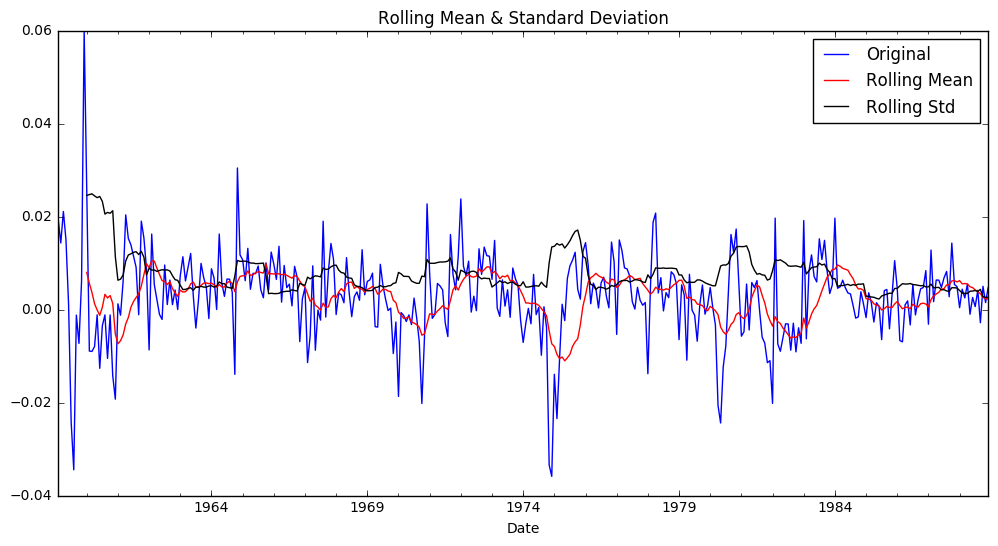

Test Statistic: -8.18789450757
p-value:  7.8095724977e-13
Critical values:  {'1%': -3.4489583388155194, '10%': -2.5711381780459002, '5%': -2.869739378430086}
единичных корней нет, ряд стационарен
Коэффициент вариации 3.2545225410567586

Ряд является интегрированным 1-ого порядка, параметр d = 1 в модели ARIMA



In [458]:
#Провереим, является ли временный ряд интегрированным порядка k
#Если первые разности ряда стационарны, то он называется интегрированным рядом первого порядка.
ts_log = np.log(ts)
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)
print('\nРяд является интегрированным 1-ого порядка, параметр d = 1 в модели ARIMA\n')

PACF => p = 1, т.к. на ней только 1 лаг сильно отличнен от нуля
ACF => q = 1, т.к. после лага 1 значении функций резко падают.


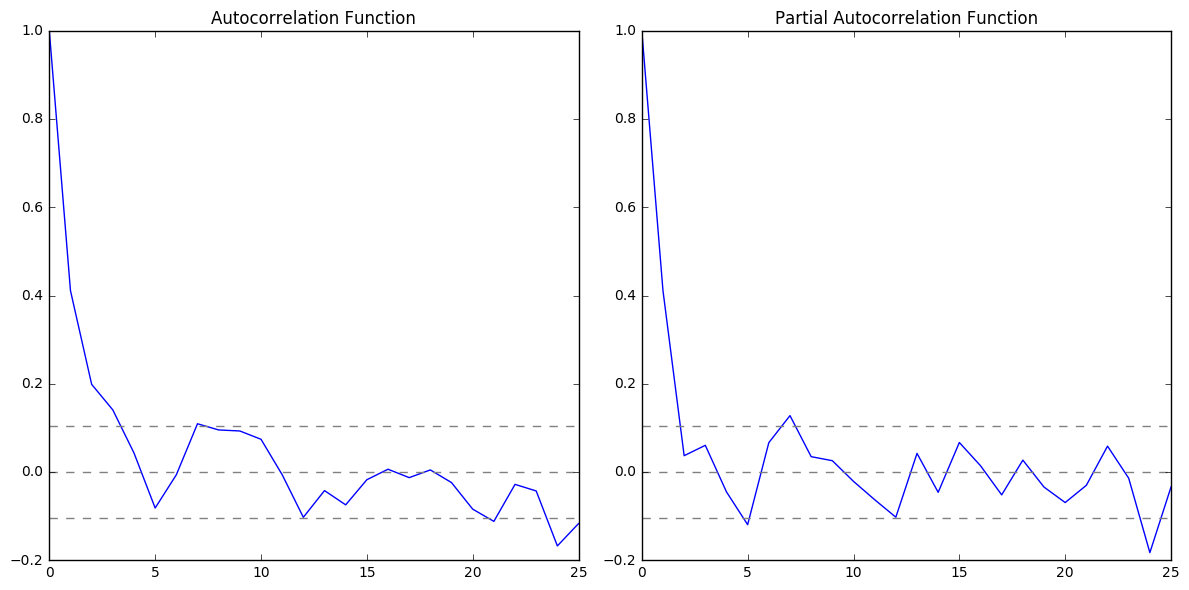

In [459]:
#Найдем параметры p и q для построения модели ARIMA. 
#Будем использовать результаты от дифференцирования, так как далее будет легче конвертировать их в исходную размерность
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=25)
lag_pacf = pacf(ts_log_diff, nlags=25, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

print('PACF => p = 1, т.к. на ней только 1 лаг сильно отличнен от нуля\nACF => q = 1, т.к. после лага 1 значении функций резко падают.')

In [429]:
from statsmodels.tsa.arima_model import ARIMA
def arimadelka(TL, TL_DIFF, p, d, q):
    TL.index = pd.to_datetime(TL.index)
    model = ARIMA(TL, order=(p, d, q))
    results_mod = model.fit(disp=-1) 
    results_mod.fittedvalues.plot(color = 'red')
    TL_DIFF.plot(color = 'blue')
    plt.title('RSS: %.4f'% sum((results_mod.fittedvalues - TL_DIFF)**2))
    return results_mod

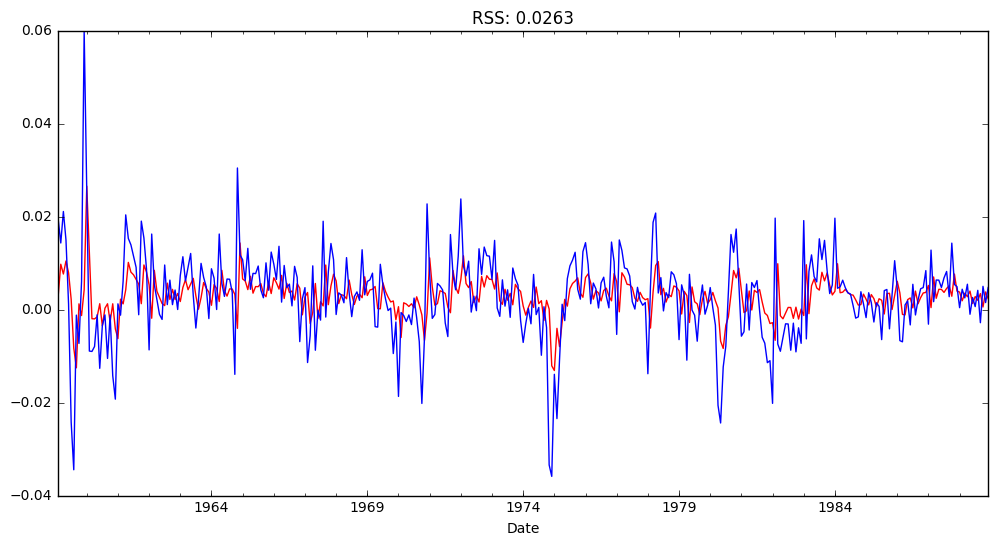

In [430]:
#AR
results_AR = arimadelka(ts_log, ts_log_diff, 1, 1, 0)

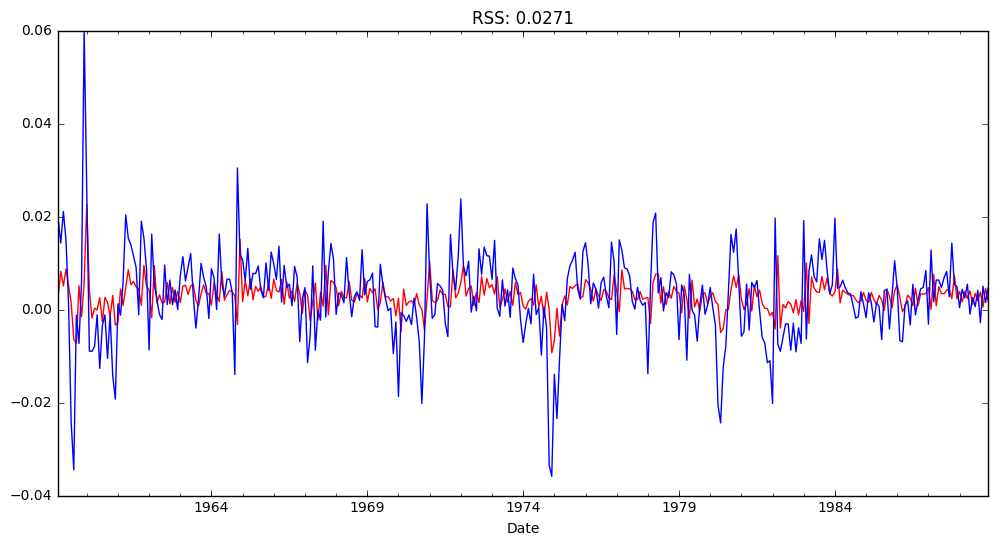

In [373]:
#MA
results_MA = arimadelka(ts_log, ts_log_diff, 0, 1, 1)

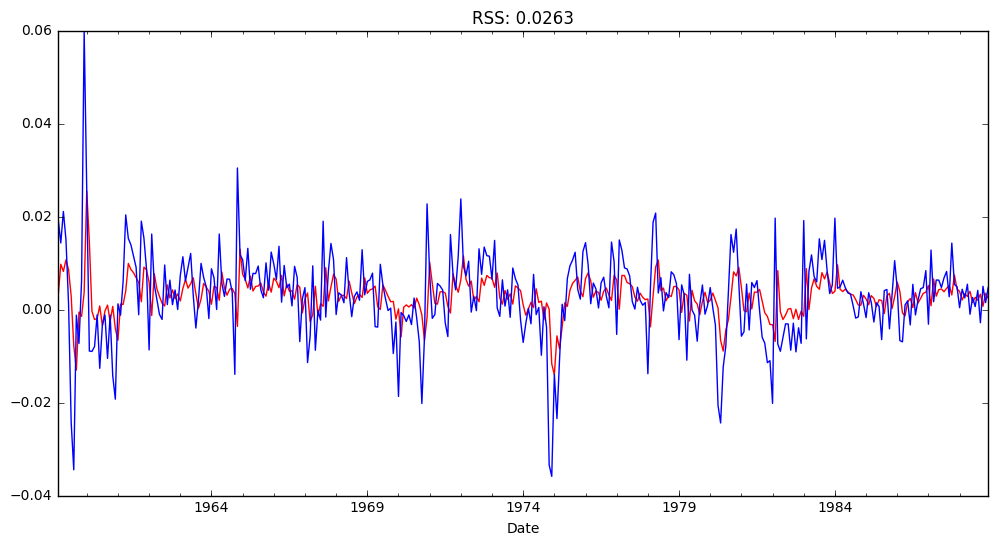

In [361]:
#ARIMA 
results_ARIMA = arimadelka(ts_log, ts_log_diff, 1, 1, 1)

In [346]:
#с помощью информационного критерия Акаике находим наилучшую модель
a = results_ARIMA.aic #0
b = results_AR.aic #1
c = results_MA.aic #2
aic = np.array([a,b,c])
if (aic.argmin() == 0):
    print('ARIMA is the BEST')
if (aic.argmin() == 1):
    print('AR is the BEST')
if (aic.argmin() == 2):
    print('MA is the BEST')

AR is the BEST


In [254]:
#функция для конвертирования ряда в исходную размерность 
def convert_to_os(predictions_mod_diff, tser_log):
 
    #print(predictions_mod_diff.head())
    predictions_mod_diff_cumsum = predictions_mod_diff.cumsum()
    #print(predictions_mod_diff_cumsum.head())
    predictions_mod_log = pd.Series(tser_log.ix[0], index=tser_log.index)
    predictions_mod_log = predictions_mod_log.add(predictions_mod_diff_cumsum,fill_value=0)
    #predictions_mod_log.head()
    predictions_mod = np.exp(predictions_mod_log)
    return predictions_mod

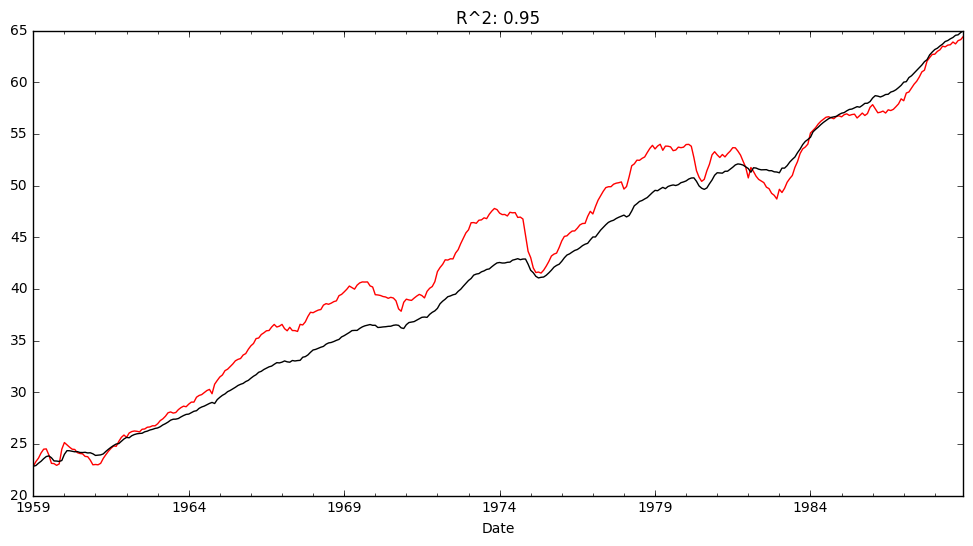

In [476]:
#Результаты модели ARIMA для исходных данных: 
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA = convert_to_os(predictions_ARIMA_diff, ts_log)
ts.index = pd.to_datetime(ts.index)
ts.plot(color = 'red')
predictions_ARIMA.plot(color = 'black')
r2 = r2_score(ts, predictions_ARIMA)
plt.title('R^2: %1.2f'% r2)

In [477]:
from sklearn.metrics import r2_score 
def forecastik(results_mod, test, test_log, col): #функция прогнозирования для тестовой выборки 
    pred = pd.Series(results_mod.predict('1989-01-01','1993-12-01', typ='linear'), copy=True)
    res = convert_to_os(pred, test_log)
    res.plot(color = col)
    test.plot()
    r2 = r2_score(test, res)
    plt.title('R^2: %1.2f'% r2)

/Users/MadiyaRR/anaconda3/lib/python3.5/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


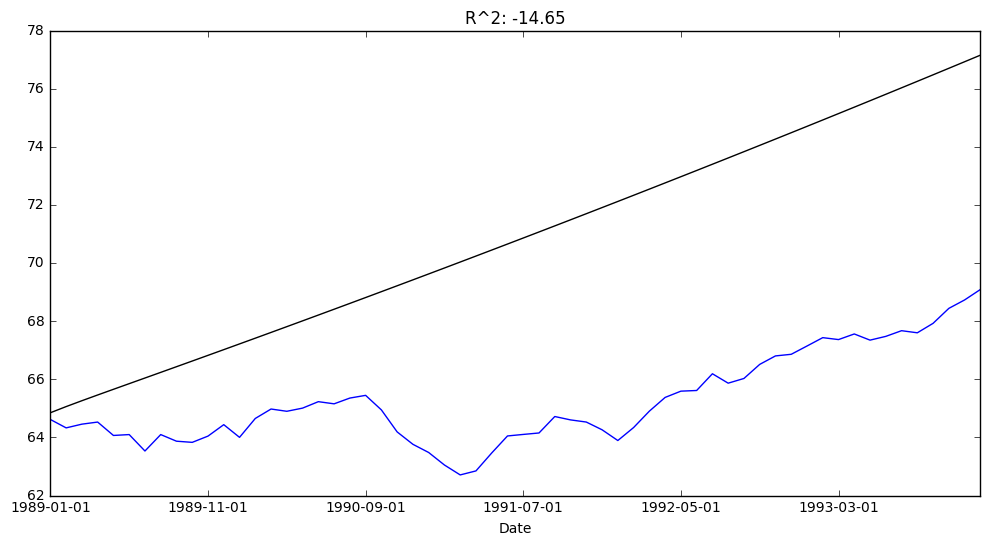

In [478]:
buf = pd.read_csv("testing.txt", index_col = 'Date')
testing = buf['Value']
testing_log = np.log(testing)
#прогнозируем для тестовой выборки в модели ARIMA
forecastik(results_ARIMA, testing, testing_log, 'black')

/Users/MadiyaRR/anaconda3/lib/python3.5/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


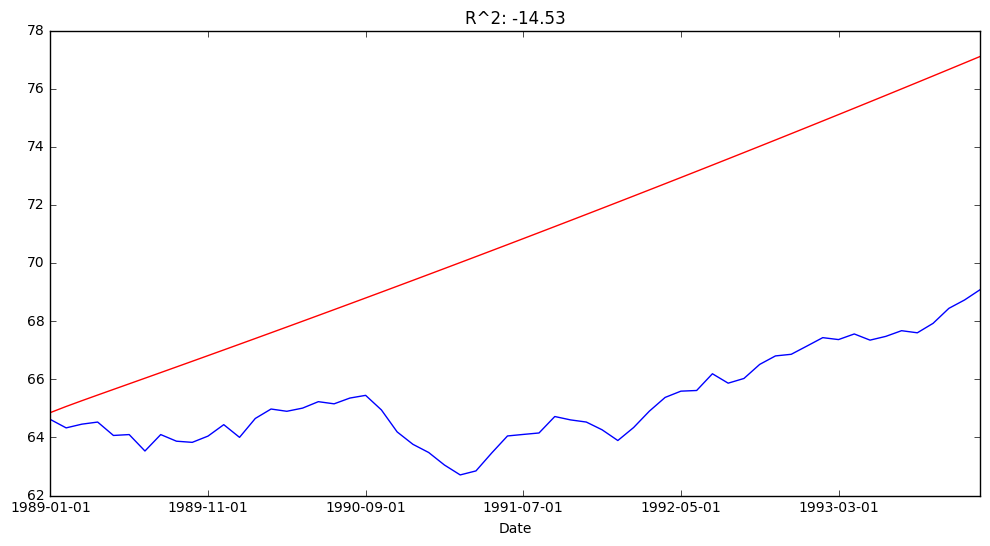

In [479]:
#прогнозируем для тестовой выборки в модели AR
forecastik(results_AR, testing, testing_log, 'red')

/Users/MadiyaRR/anaconda3/lib/python3.5/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


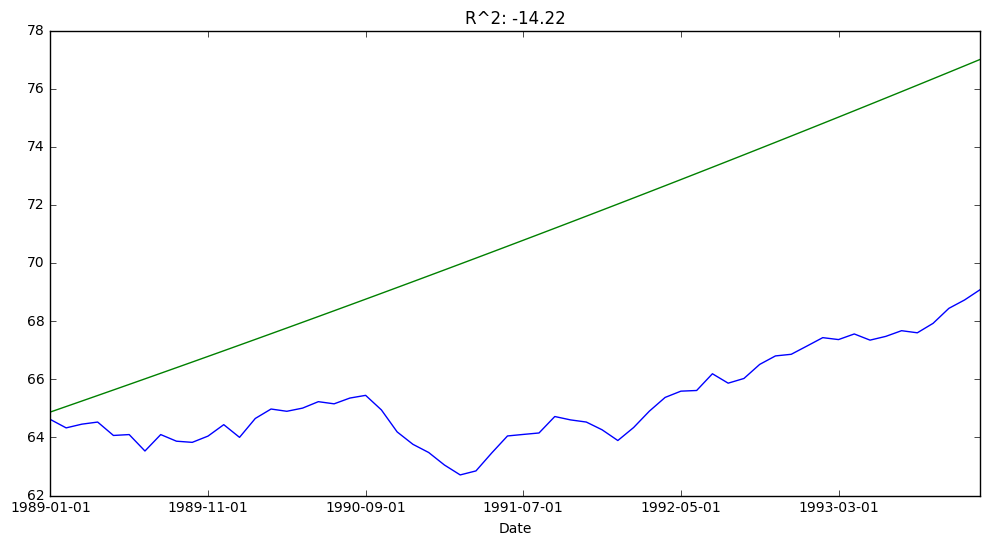

In [480]:
#прогнозируем для тестовой выборки в модели MA
forecastik(results_MA, testing, testing_log, 'green')